In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 36.3 MB/s 
     |████████████████████████████████| 448 kB 53.8 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [7]:
def preprocess(text):
  text = re.sub(r"[^A-Za-zㄱ-ㅎㅏ-ㅣ가-힣0-9]","", text) # 영어,한글만 포함
  return text

train['preproc'] = train.document.apply(lambda x : preprocess(x))
test['preproc'] = test.document.apply(lambda x : preprocess(x))

train.tail()

,id,document,label,preproc
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0,좋은배우들로3류영화를찍은안타까운영화
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0,진짜드럽게재미없다에드워드호퍼그림에배경빼고는볼게아닌영화
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0,가장실망스러운영화지금까지본영화중
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1,이런평점테러네이버에서좀막아야하는것아닌가
4999,5000,"여주인공이 전작에서는 귀여웠는데, 여기선 완전 망했네, 실망이다",0,여주인공이전작에서는귀여웠는데여기선완전망했네실망이다


In [8]:
stopwords = ['의','가','이','은','는','좀','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train = []
for sentence in train['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in test['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

print(X_train[:3])

[['영상', '이나', '음악', '이쁘다', '도미', '화', '시키다', '불륜', '일', '뿐'], ['히치콕', '이영화', '보다', '분명', '박수', '치다'], ['괜찮다', '음악', '영화', '또', '나오다', '따뜻하다', '겨울', '되다', '같다']]


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7370
등장 빈도가 2번 이하인 희귀 단어의 수: 5265
단어 집합에서 희귀 단어의 비율: 71.438263229308
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 15.227987610151992


In [15]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2106


In [16]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[284, 121, 200, 244, 122, 318, 932, 157, 162], [45, 2, 741, 1092, 415], [158, 200, 1, 145, 41, 220, 1587, 19, 22]]


In [17]:
y_train = np.array(train['label'])

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
print(len(X_train), len(y_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train), len(y_train))

5000 5000
4964 4964


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 19
리뷰의 평균 길이 : 7.112207896857373


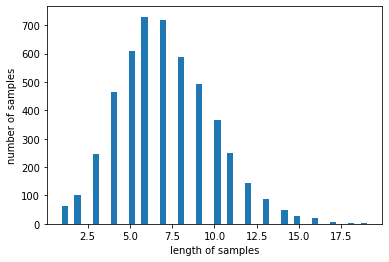

In [18]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [34]:
max_len = 13
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.0


In [35]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/15
31/32 [============================>.] - ETA: 0s - loss: 0.6052 - acc: 0.6845
Epoch 00001: val_acc improved from -inf to 0.72004, saving model to best_model.h5
32/32 [==============================] - 5s 82ms/step - loss: 0.6051 - acc: 0.6847 - val_loss: 0.5148 - val_acc: 0.7200
Epoch 2/15
31/32 [============================>.] - ETA: 0s - loss: 0.3665 - acc: 0.8556
Epoch 00002: val_acc improved from 0.72004 to 0.74522, saving model to best_model.h5
32/32 [==============================] - 2s 63ms/step - loss: 0.3663 - acc: 0.8557 - val_loss: 0.5377 - val_acc: 0.7452
Epoch 3/15
31/32 [============================>.] - ETA: 0s - loss: 0.2654 - acc: 0.8911
Epoch 00003: val_acc improved from 0.74522 to 0.81168, saving model to best_model.h5
32/32 [==============================] - 2s 67ms/step - loss: 0.2654 - acc: 0.8912 - val_loss: 0.4640 - val_acc: 0.8117
Epoch 4/15
31/32 [============================>.] - ETA: 0s - loss: 0.2107 - acc: 0.9131
Epoch 00004: val_acc improved fr

(array([1444.,  285.,  148.,  145.,  103.,   81.,   88.,   82.,  150.,
          90.,   71.,   85.,   68.,   92.,   89.,  108.,  115.,  191.,
         280., 1285.]),
 array([4.76722153e-06, 5.00035621e-02, 1.00002356e-01, 1.50001153e-01,
        1.99999958e-01, 2.49998748e-01, 2.99997538e-01, 3.49996328e-01,
        3.99995148e-01, 4.49993938e-01, 4.99992728e-01, 5.49991548e-01,
        5.99990308e-01, 6.49989128e-01, 6.99987888e-01, 7.49986708e-01,
        7.99985528e-01, 8.49984288e-01, 8.99983108e-01, 9.49981868e-01,
        9.99980688e-01], dtype=float32),
 <a list of 20 Patch objects>)

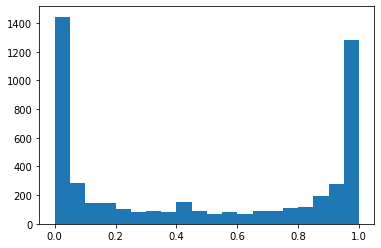

In [37]:
loaded_model = load_model('best_model.h5')
pred = loaded_model.predict(X_test)
plt.hist(pred, bins=20)

In [38]:
result = [0 if val < 0.5 else 1 for val in pred]
sub['label'] = result
sub.to_csv("baseline.csv", index=False)